In [6]:
# ! pip3 install gdown
# ! pip3 install zipfile
# ! pip3 install neurora

# Import libraries and modules

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from six.moves import urllib
import gdown
import zipfile
from scipy.io import loadmat       # Import function to read data.
from neurora.decoding import tbyt_decoding_kfold
from neurora.rsa_plot import plot_tbyt_decoding_acc, plot_rdm, plot_tbytsim_withstats
from neurora.rdm_cal import eegRDM
from neurora.corr_cal_by_rdm import rdms_corr
from IPython.lib.display import YouTubeVideo

# Case Studies

## Classification-based Decoding

### Basketball and Cat

#### Download and import data

**From Google Drive to Current Folder**

In [135]:
data_dir = 'seminar_data/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [136]:
print('================ Demo - Binary Classification ================')

id = '13bCcdHGVfU6-ahgu95d-W5hkwPAmvNB-'
filename = 'data1.zip'
filepath = data_dir + filename

# Download the data
gdown.download(id=id, output=filepath, quiet=False, fuzzy=True)
print('Download completes!')
# unzip the data
with zipfile.ZipFile(filepath, 'r') as zip:
    zip.extractall(data_dir)
print("Unzip completes!")

================ Demo - Binary Classification ================


Downloading...
From: https://drive.google.com/uc?id=13bCcdHGVfU6-ahgu95d-W5hkwPAmvNB-
To: /home/boiqm/Documents/PhD/REMESH_Seminar/seminar_data/data1.zip
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20.9M/20.9M [00:00<00:00, 82.5MB/s]

Download completes!
Unzip completes!


**Load the data into Python**

In [137]:
data1 = np.load(data_dir + 'data1/data.npy')
labels1 = np.load(data_dir + 'data1/labels.npy')

#### Data Exploratory

To understand the outcome of issuing this command, let's examine the variable `data` now present in the workspace.

In [139]:
type(data1)

numpy.ndarray

In [141]:
data1.shape, labels1.shape

(10, 160, 17, 100)

***Information***

**data**
* 10: number of subjects
* 160: number of trials
* 17: number of channels
* 100: number of time points

**labels**
* 0: Basketball
* 1: Cat

In [143]:
_, ntrials, _, nsamples = data1.shape

In [145]:
ntrials, nsamples

(160, 100)

With this syntax:
* We assign the variable `ntrials` to the value `data1.shape[1]`, which is the number of rows.
* We assign the variable `nsamples` to the value `data1.shape[3]`, which is the number of columns.

In [167]:
# Create the time vector
t = np.linspace(-0.2, 0.8, nsamples)

In [168]:
t.shape

(100,)

#### Visual Inspection

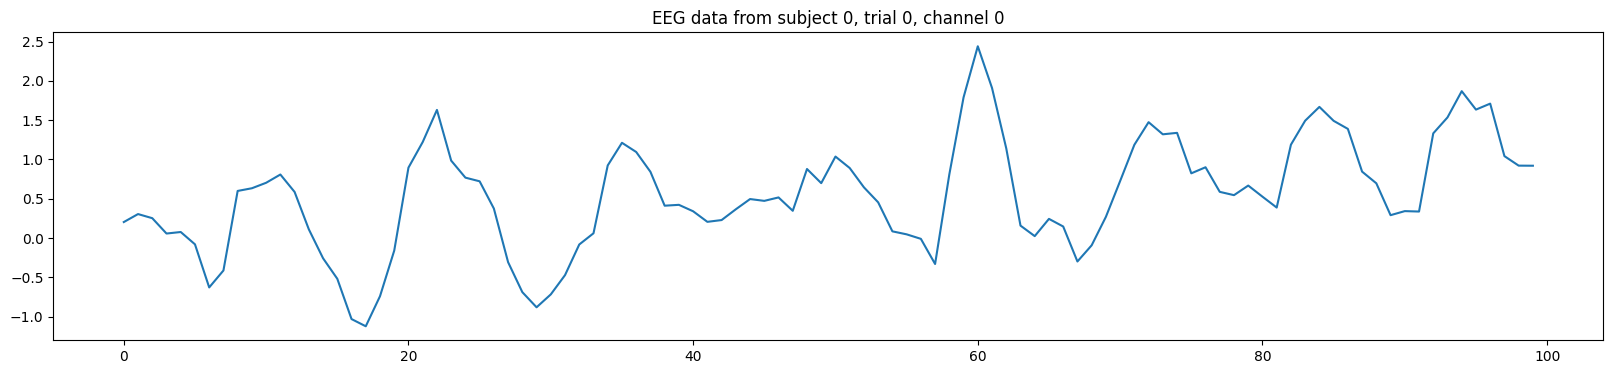

In [148]:
subject_id = 0
trial_id = 0
channel_id = 0
test = data1[subject_id][trial_id][channel_id]

plt.figure(figsize=(20, 4))
plt.plot(test)  
plt.title('EEG data from subject 0, trial 0, channel 0') # And give it a title.
plt.show()

Visualising the data in this way, we immediately notice many features. First, let's consider the axes. The horizontal axis extends from 0 to (nearly) 100. This corresponds to the time points in the variable `data1`. The sampling frequency of 100 Hz corresponds to one sample of the EEG data every 1/(100 Hz) = 0.01 s = 10 ms.

**Plot both labels**

In [157]:
subject_id = 0
channel_id = 0

EEG = data1[subject_id, :, channel_id, :]
EEG_data = EEG.reshape(160, 100)

labels = labels1[subject_id]

In [161]:
# EEGa will contain columns of data where the corresponding label is 0: basketball
EEGa = EEG_data[labels == 0, :]

# EEGb will contain columns of data where the corresponding label is 1: cat
EEGb = EEG_data[labels == 1, :]

In [162]:
EEGa.shape, EEGb.shape

((80, 100), (80, 100))

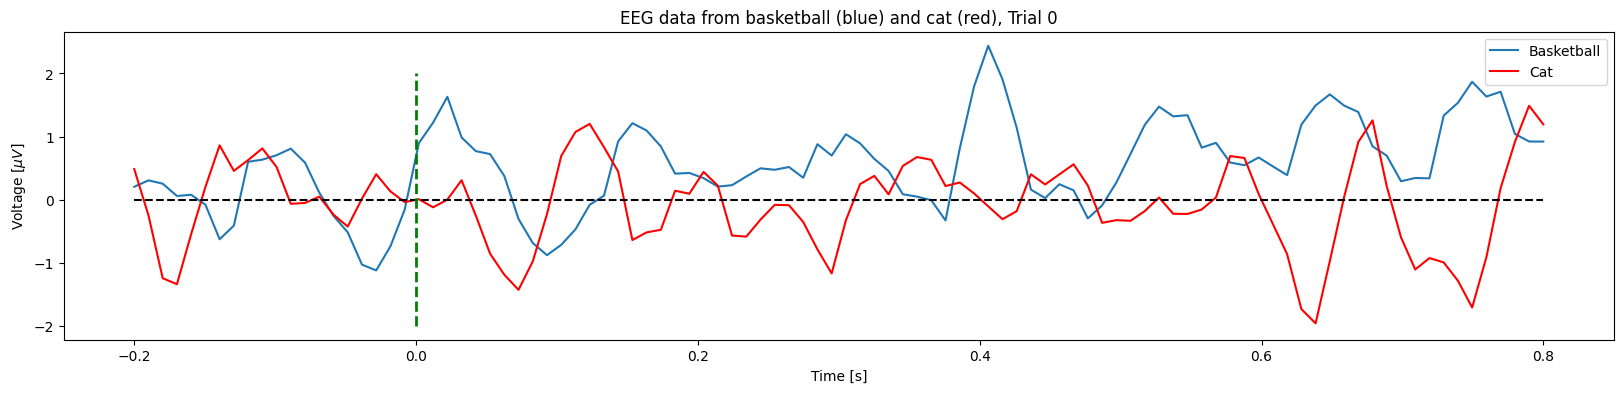

In [171]:
plt.figure(figsize=(20, 4))         # Resize the figure to make it easier to see
plt.plot(t,EEGa[0], label='Basketball')                 # Plot condition A, trial 1, data vs t,
plt.plot(t,EEGb[0], 'r', label = 'Cat')            # ... and the data from condition B, trial 1,
plt.xlabel('Time [s]')              # Label the x-axis as time.
plt.ylabel('Voltage [$\mu V$]')       # Label the y-axis as voltage.
plt.title('EEG data from basketball (blue) and cat (red), Trial 0') # And give it a title.
plt.hlines(0, t[0], t[-1], 'black', '--')
# Add a vertical line to indicate the stimulus time
plt.plot([0, 0], [-2,2], '--', color='g', lw=2)
plt.legend()
plt.savefig('images/ppt/EEG-binary_classification.png')
plt.show()

**Comment:**
Visual inspection of the EEG data has so far come up empty. The EEG traces appear noisy or perhaps rhythmic, but from visual inspection of the individual trials, it's difficult to make a decisive conclusion of underlying structure figure.

To further investigate the activity in these data, we compute the **event-related potential** (ERP)

To compute the ERP, we first assume that each trial evokes an instantiation of the same underlying brain process. So, in this case, we assume that the same brain  response is evoked 1,000 times (once for each trial) for each condition. However, the evoked response due to the stimulus is small and hidden in the EEG signal by other ongoing activity unrelated to the stimulus (e.g., daydreaming, thoughts of dinner, thoughts of homework). Therefore, to tease out the weak evoked effect, **we average the EEG response across trials**. Ideally, EEG activity unrealated to the stimulus will cancel out in the average, while EEG activity evoked by the stimulus will sum constructively. The procedure to perform and display this averaging can be done in Python as follows:

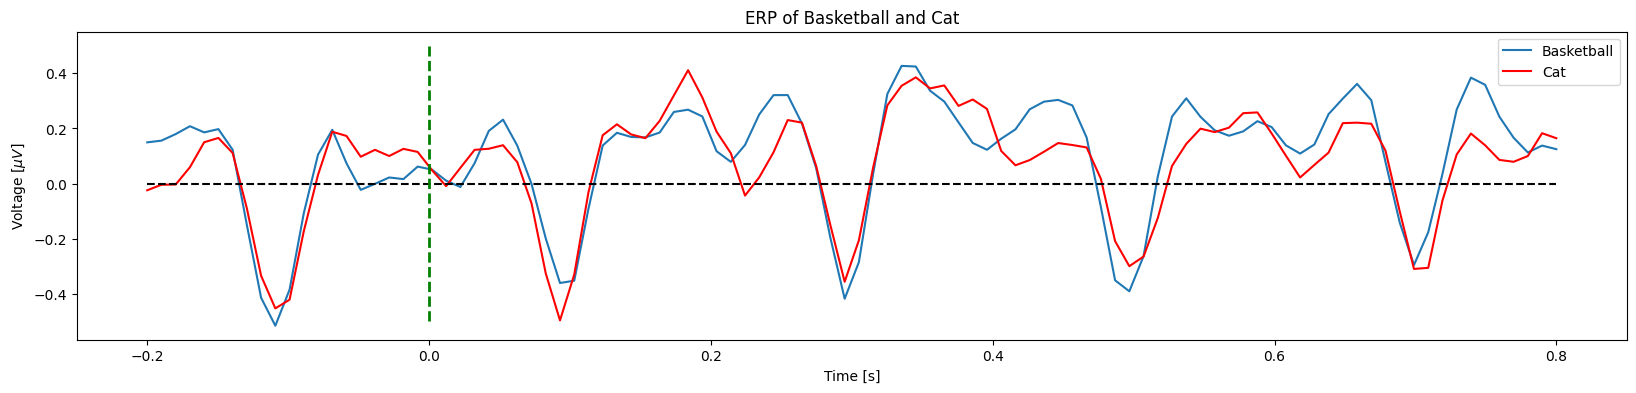

In [178]:
plt.figure(figsize=(20, 4))         # Resize the figure to make it easier to see
plt.plot(t, EEGa.mean(0), label='Basketball')        # Plot the ERP of condition A
plt.plot(t, EEGb.mean(0), 'r', label='Cat')        # Plot the ERP of condition B
plt.xlabel('Time [s]')           # Label the axes
plt.ylabel('Voltage [$\mu V$]')
plt.title('ERP of Basketball and Cat')  # ... provide a title
plt.hlines(0, t[0], t[-1], 'black', '--')
# Add a vertical line to indicate the stimulus time
plt.plot([0, 0], [-0.5,0.5], '--', color='g', lw=2)
plt.legend()
plt.savefig('images/ppt/ERP-binary-classification.png')
plt.show()                       # ... and show the plot

#### Decoding EEG signals

In [181]:
# This is the easiest way to do decoding
# A ready-made function: tbyt_decoding_kfold()
help(tbyt_decoding_kfold)

Help on function tbyt_decoding_kfold in module neurora.decoding:

tbyt_decoding_kfold(data, labels, n=2, navg=5, time_opt='average', time_win=5, time_step=5, nfolds=5, nrepeats=2, normalization=False, pca=False, pca_components=0.95, smooth=True)
    Conduct time-by-time decoding for EEG-like data (cross validation)
    
    Parameters
    ----------
    data : array
        The neural data.
        The shape of data must be [n_subs, n_trials, n_chls, n_ts]. n_subs, n_trials, n_chls and n_ts represent the
        number of subjects, the number of trails, the number of channels and the number of time-points.
    labels : array
        The labels of each trial.
        The shape of labels must be [n_subs, n_trials]. n_subs and n_trials represent the number of subjects and the
        number of trials.
    n : int. Default is 2.
        The number of categories for classification.
    navg : int. Default is 5.
        The number of trials used to average.
    time_opt : string "average" or

In [182]:
accuracies = tbyt_decoding_kfold(data1, labels1, n=2, navg=5, time_win=1, time_step=1, nfolds=3, nrepeats=3)

Calculating: [====================================================================================================] 100.00%
Decoding finished!



**How to choose number of folds? (Number of averages)**

- Tentative answer: Largest number of folds possible to achieve ~ 15 trials per averages

*For example*:

* 40 trials/class: 3 folds
* 60 trials/class: 4 folds
* 100 trials/class: 7 folds

**Check decoding redults**

In [183]:
print(accuracies.shape)

(10, 100)


**Plot decoding results**

In [185]:
# This is the easiest way to plot decoding results
# A ready-made function: plot_tbyt_decoding_acc()
help(plot_tbyt_decoding_acc)

Help on function plot_tbyt_decoding_acc in module neurora.rsa_plot:

plot_tbyt_decoding_acc(acc, start_time=0, end_time=1, time_interval=0.01, chance=0.5, p=0.05, cbpt=True, clusterp=0.05, stats_time=[0, 1], color='r', xlim=[0, 1], ylim=[0.4, 0.8], xlabel='Time (s)', ylabel='Decoding Accuracy', figsize=[6.4, 3.6], x0=0, ticksize=12, fontsize=16, markersize=2, title=None, title_fontsize=16, avgshow=False)
    Plot the time-by-time decoding accuracies
    
    Parameters
    ----------
    acc : array
        The decoding accuracies.
        The size of acc should be [n_subs, n_ts]. n_subs, n_ts represent the number of subjects and number of
        time-points.
    start_time : int or float. Default is 0.
        The start time.
    end_time : int or float. Default is 1.
        The end time.
    time_interval : float. Default is 0.01.
        The time interval between two time samples.
    chance : float. Default is 0.5.
        The chance level.
    p : float. Default is 0.05.
       


Significant time-windows:
70ms to 550ms
610ms to 669ms


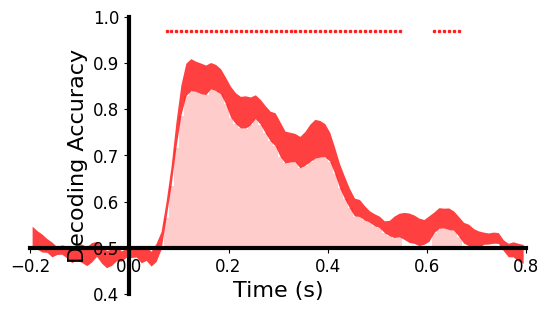

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [187]:
plot_tbyt_decoding_acc(accuracies, start_time=-0.2, end_time=0.8, time_interval=0.01, chance=0.5, p=0.05, 
                       cbpt=False, stats_time=[0, 0.8], color='r', xlim=[-0.2, 0.8], ylim=[0.4, 1])


Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!


Significant time-windows:
70ms to 550ms
610ms to 669ms


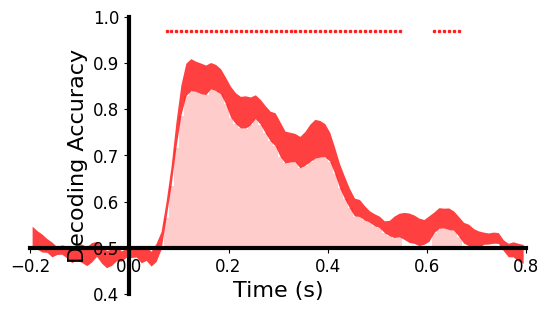

In [191]:
fig = plt.figure(figsize=(15, 5))         # Resize the figure to make it easier to see
plot_tbyt_decoding_acc(accuracies, start_time=-0.2, end_time=0.8, time_interval=0.01, chance=0.5, p=0.05, 
                       cbpt=True, stats_time=[0, 0.8], color='r', xlim=[-0.2, 0.8], ylim=[0.4, 1])
fig.savefig('images/ppt/decoding-binary-classification.png')

### Working memory

#### Download and import data

**From Google Drive to Current Folder**

In [192]:
print('================ Demo - Multiclass Classification ================')

id = '1SaDPoY65XdgrymEznQlvVLb3M4z59wAS'
filename = 'data2.zip'
filepath = data_dir + filename

# Download the data
gdown.download(id=id, output=filepath, quiet=False, fuzzy=True)
print('Download completes!')
# unzip the data
with zipfile.ZipFile(filepath, 'r') as zip:
    zip.extractall(data_dir)
print("Unzip completes!")

================ Demo - Multiclass Classification ================


Downloading...
From (original): https://drive.google.com/uc?id=1SaDPoY65XdgrymEznQlvVLb3M4z59wAS
From (redirected): https://drive.google.com/uc?id=1SaDPoY65XdgrymEznQlvVLb3M4z59wAS&confirm=t&uuid=38a45cfd-c4a8-4580-b0a8-fafcdd919230
To: /home/boiqm/Documents/PhD/REMESH_Seminar/seminar_data/data2.zip
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 184M/184M [00:02<00:00, 84.4MB/s]


Download completes!
Unzip completes!


**Load the data into Python**

In [ ]:
data2 = np.load(data_dir + 'data2/data.npy')
labels2 = np.load(data_dir + 'data2/labels.npy')

#### Data Exploratory

In [193]:
print(np.shape(data2))
print(np.shape(labels2))

(5, 640, 27, 500)
(5, 640)


***Information***

**data**
* 5: number of subjects
* 640: number of trials
* 27: number of channels
* 500: number of time points (-0.5s to 1.5s, sample frequence = 250 => time interval = 0.004)

**labels**
16 orientations:
* $0: 0^0$
* $1: 22.5^0$
* $2: 45^0$ 
* $3: 67.5^0$ 
* ...
* $14: 315^0$ 
* $15: 337.5^0$ 

In [194]:
_, ntrials, _, nsamples = data2.shape

In [196]:
# Create the time vector
t = np.linspace(-0.5, 1.5, nsamples)

In [197]:
t.shape

(500,)

#### Visual Inspection

**One versus All**

In [199]:
subject_id = 0
channel_id = 0

EEG = data2[subject_id, :, channel_id, :]
EEG_data = EEG.reshape(640, 500)

labels = labels2[subject_id]

In [200]:
# EEGa will contain columns of data where the corresponding label is 0
EEGa = EEG_data[labels == 0, :]

# EEGb will contain columns of data where the corresponding others
EEGb = EEG_data[labels != 0, :]

In [201]:
EEGa.shape, EEGb.shape

((40, 500), (600, 500))

In [209]:
def visualise_one_vs_all(ax, label, EEG_data, i, degrees):
    # EEGa will contain columns of data where the corresponding label
    EEGa = EEG_data[labels == label, :]

    # EEGb will contain columns of data where the corresponding others
    EEGb = EEG_data[labels != label, :]
    
    #Plot
    ax.plot(t, EEGa.mean(0), label=f'{degrees[i]}')        # Plot the ERP of label ...
    ax.plot(t, EEGb.mean(0), 'r', label='Others')   # Plot the ERP of others
    ax.set_xlabel('Time [s]')           # Label the axes
    ax.set_ylabel('Voltage [$\mu V$]')
    ax.set_title(f'ERP of {degrees[i]} and others')  # ... provide a title
    ax.axvline(x=0, linestyle="--", color="darkgrey")
    ax.axhline(y=0, linestyle="--", color="darkgrey")
    ax.legend()

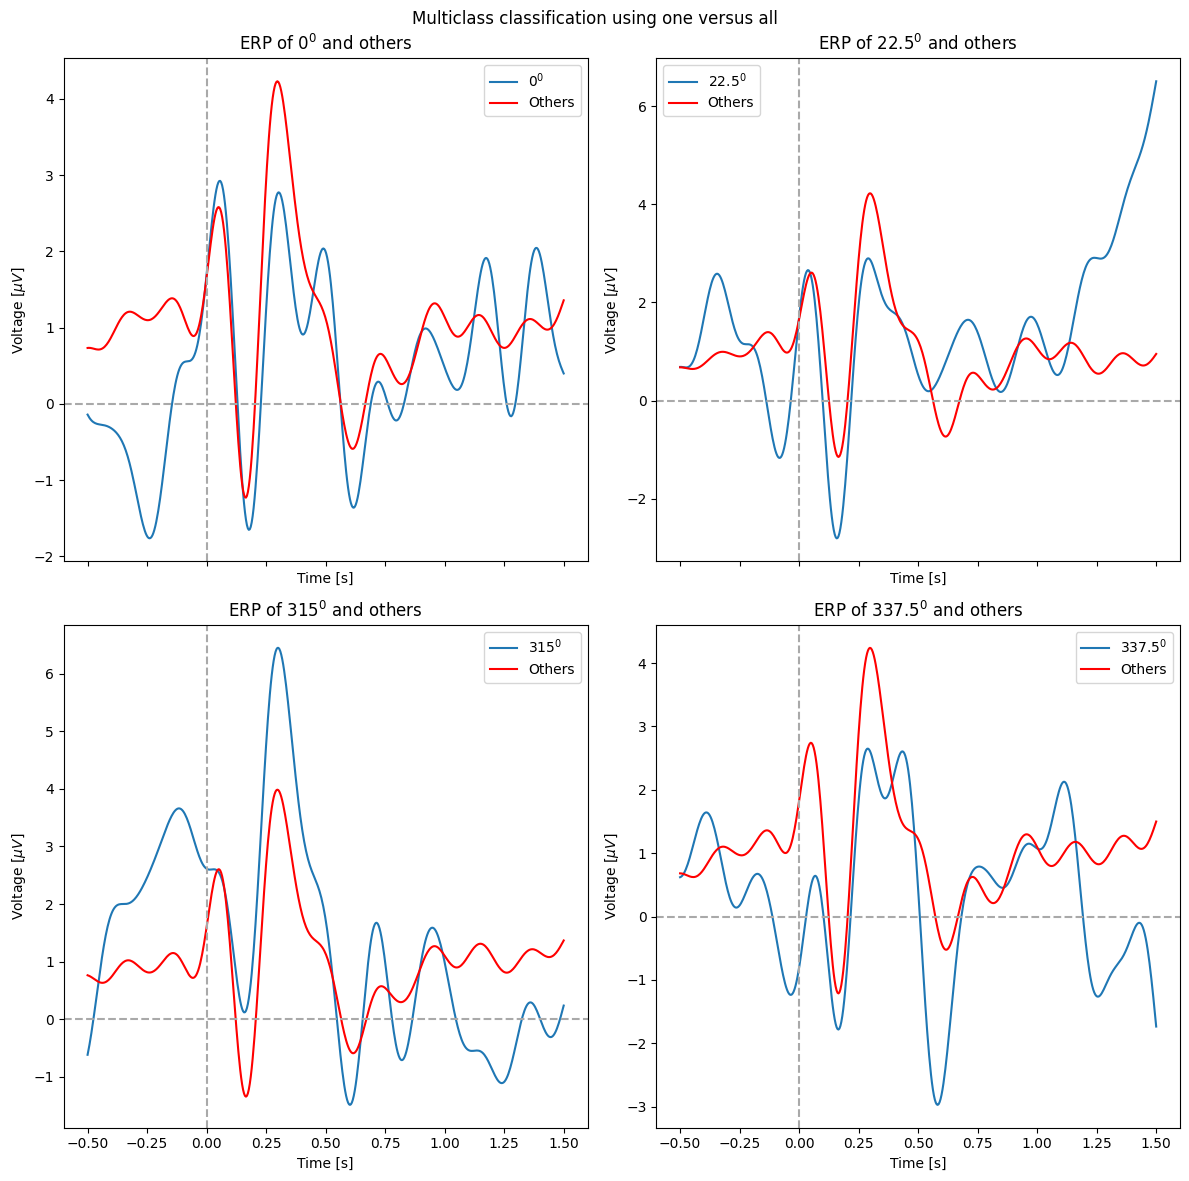

In [213]:
# Visualize
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(12, 12))
axs = axs.flatten()
orientations = [0, 1, 14, 15]
degrees = ['$0^0$', '$22.5^0$', '$315^0$', '$337.5^0$'] 
for i, label in enumerate(orientations):
    visualise_one_vs_all(axs[i], label, EEG_data, i, degrees)
plt.suptitle('Multiclass classification using one versus all')
plt.tight_layout() 
plt.savefig('images/ppt/ERP-multiclass-classification.png')
plt.show()                       # ... and show the plot

#### Decoding EEG signals

In [222]:
accuracies = tbyt_decoding_kfold(data2, labels2, n=16, navg=3, time_win=1, time_step=1, nfolds=5, nrepeats=5)

Calculating: [====================================================================================================] 100.00%
Decoding finished!



**Check decoding redults**

In [215]:
print(accuracies.shape)

(5, 500)


**Plot decoding results**


Significant time-windows:
64ms to 87ms
91ms to 95ms
148ms to 184ms
188ms to 196ms
219ms to 580ms
588ms to 632ms
652ms to 659ms
724ms to 772ms
776ms to 796ms
800ms to 812ms
816ms to 820ms
824ms to 828ms
1404ms to 1408ms
1460ms to 1476ms
1484ms to 1496ms


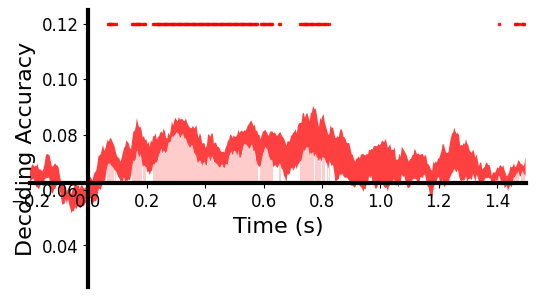

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [219]:
plot_tbyt_decoding_acc(accuracies, start_time=-0.5, end_time=1.5, time_interval=0.004, chance=0.0625, p=0.05, 
                       cbpt=False, stats_time=[0, 1.5], color='r', xlim=[-0.2, 1.5], ylim=[0.025, 0.125])


Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!


Significant time-windows:
140ms to 223ms
256ms to 584ms
640ms to 671ms
728ms to 796ms


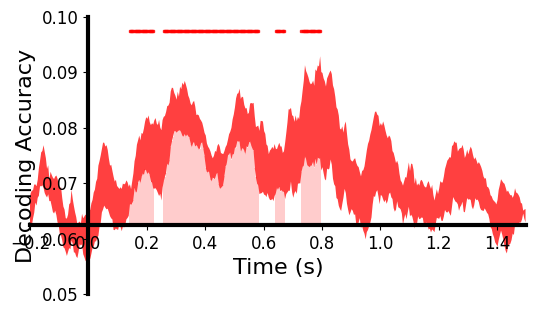

In [258]:
fig = plt.figure(figsize=(15, 5))         # Resize the figure to make it easier to see
plot_tbyt_decoding_acc(accuracies, start_time=-0.5, end_time=1.5, time_interval=0.004, chance=0.0625, p=0.05, 
                       cbpt=True, stats_time=[0, 1.5], color='r', xlim=[-0.2, 1.5], ylim=[0.05, 0.1])
fig.savefig('images/ppt/classification-based-decoding-result.png')

## RSA-based Decoding

### Working memory

#### Build RDM for orientation representations

**Assumption:**
* The closer the two orientations are, the higher the similarity is (the lower the dissimilarity is).
* The less close the two orientations are, the lower the similarity is (the higher the dissimilarity is).

In [223]:
oriRDM = np.zeros([16, 16])
for i in range(16):
    for j in range(16):
        diff = np.abs(i - j)
        if diff <= 8:
            oriRDM[i, j] = diff / 8
        else:
            oriRDM[i, j] = (16 - diff) / 8
print(oriRDM)

[[0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.    0.875 0.75  0.625
  0.5   0.375 0.25  0.125]
 [0.125 0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.    0.875 0.75
  0.625 0.5   0.375 0.25 ]
 [0.25  0.125 0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.    0.875
  0.75  0.625 0.5   0.375]
 [0.375 0.25  0.125 0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.
  0.875 0.75  0.625 0.5  ]
 [0.5   0.375 0.25  0.125 0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875
  1.    0.875 0.75  0.625]
 [0.625 0.5   0.375 0.25  0.125 0.    0.125 0.25  0.375 0.5   0.625 0.75
  0.875 1.    0.875 0.75 ]
 [0.75  0.625 0.5   0.375 0.25  0.125 0.    0.125 0.25  0.375 0.5   0.625
  0.75  0.875 1.    0.875]
 [0.875 0.75  0.625 0.5   0.375 0.25  0.125 0.    0.125 0.25  0.375 0.5
  0.625 0.75  0.875 1.   ]
 [1.    0.875 0.75  0.625 0.5   0.375 0.25  0.125 0.    0.125 0.25  0.375
  0.5   0.625 0.75  0.875]
 [0.875 1.    0.875 0.75  0.625 0.5   0.375 0.25  0.125 0.    0.125 0.25
  0.375 0.5   0.625 0.75 

In [234]:
oriRDM.shape

(16, 16)

#### Plot orientation RDM

1


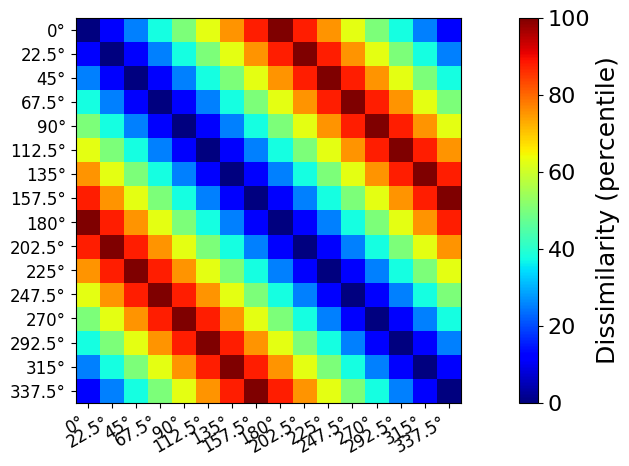

In [238]:
conditions = ["0°", "22.5°", "45°", "67.5°", "90°", "112.5°", "135°", "157.5°", "180°",
              "202.5°", "225°", "247.5°", "270°", "292.5°", "315°", "337.5°"]

# A ready-made function: plot_rdm
fig = plt.figure(figsize=(15, 5))         # Resize the figure to make it easier to see
plot_rdm(oriRDM, conditions=conditions, percentile=True)
fig.savefig('images/ppt/rdm-orientations.png')

#### Build RDMs for EEG

In [228]:
data2.shape

(5, 640, 27, 500)

**Goal**

16 orientations -> 16 conditions

The shape of RDM should be 16 * 16
* Input: EEG: 5 * 640 * 27 * 500 -> 16 * 5 * 40 * 27 * 500
* Output: RDM: 5 * 500 * 16 * 16

In [229]:
data2_16conditions = np.zeros([16, 5, 40, 27, 500])
for sub in range(5):
    index = np.zeros([16], dtype=int)
    for i in range(640):
        condition = int(labels2[sub, i])
        data2_16conditions[condition, sub, index[condition]] = data2[sub, i]
        index[condition] = index[condition] + 1

In [230]:
data2_16conditions.shape

(16, 5, 40, 27, 500)

In [231]:
# This is the easiest way to calculate RDMs
# A ready-made function: eegRDM()
help(eegRDM)

Help on function eegRDM in module neurora.rdm_cal:

eegRDM(EEG_data, sub_opt=1, chl_opt=0, time_opt=0, time_win=5, time_step=5, method='correlation', abs=False)
    Calculate the Representational Dissimilarity Matrix(Matrices) - RDM(s) based on EEG-like data
    
    Parameters
    ----------
    EEG_data : array
        The EEG/MEG/fNIRS data.
        The shape of EEGdata must be [n_cons, n_subs, n_trials, n_chls, n_ts].
        n_cons, n_subs, n_trials, n_chls & n_ts represent the number of conidtions, the number of subjects, the number
        of trials, the number of channels & the number of time-points, respectively.
    sub_opt: int 0 or 1. Default is 1.
        Return the subject-result or average-result.
        If sub_opt=0, return the average result.
        If sub_opt=1, return the results of each subject.
    chl_opt : int 0 or 1. Default is 0.
        Calculate the RDM for each channel or not.
        If chl_opt=0, calculate the RDM based on all channels'data.
        If c

In [232]:
eegRDMs = eegRDM(data2_16conditions, sub_opt=1, chl_opt=0, time_opt=1, time_win=1, time_step=1)


Computing RDMs
Calculating: [====================================================================================================] 100.00%
RDMs computing finished!


In [233]:
print(eegRDMs.shape)

(5, 500, 16, 16)


#### Plot EEG RDM

In [246]:
def visualise_EEG_RDM(subject_id, time_point):
    EEGrdm = eegRDMs[subject_id,time_point,:,:]
    EEGrdm = EEGrdm.reshape(16,16)
    plot_rdm(EEGrdm, conditions=conditions, percentile=True, title=f"EEG RDM of subject {subject_id} at time point {time_point}")

1


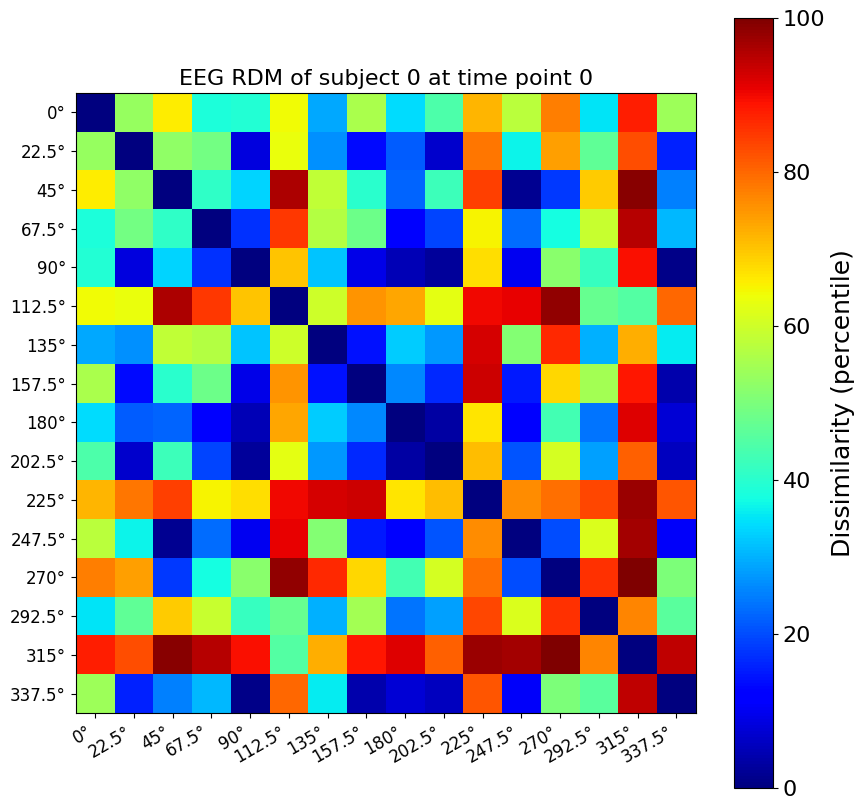

1


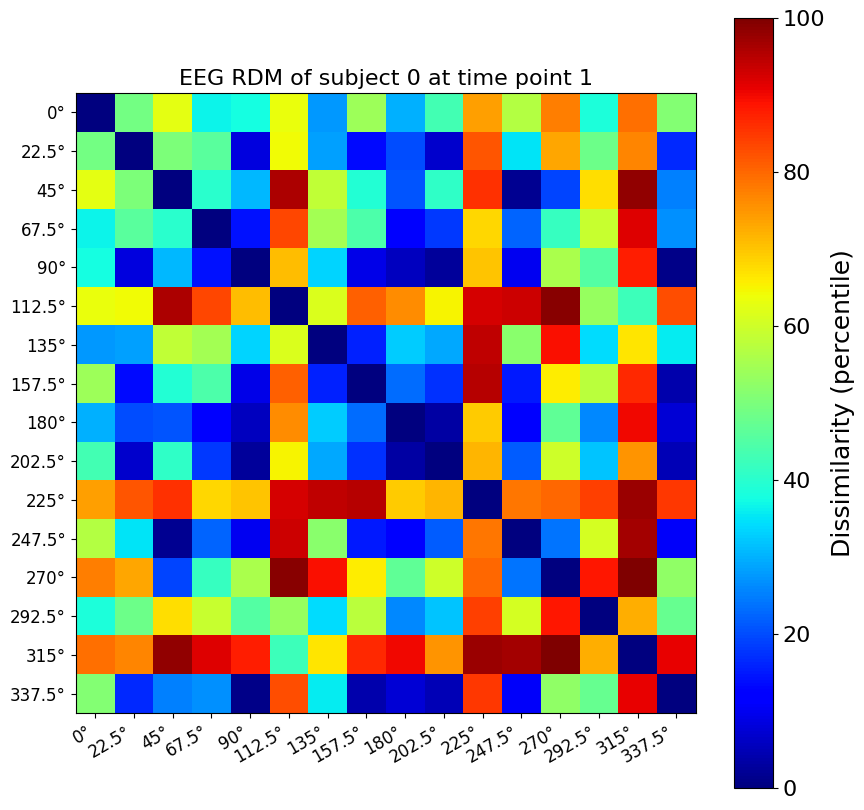

1


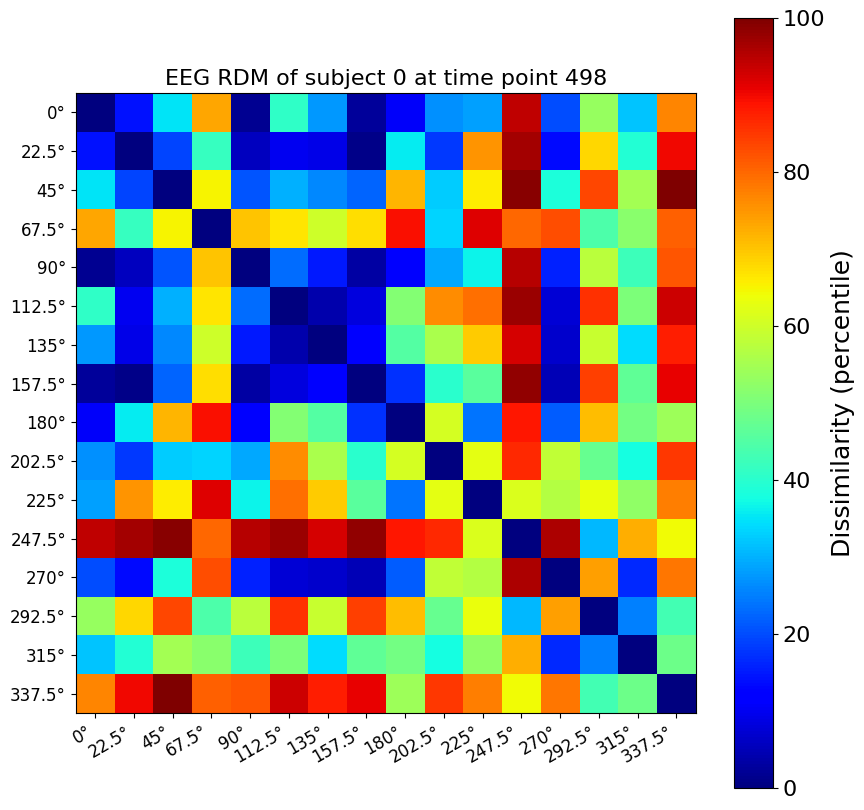

1


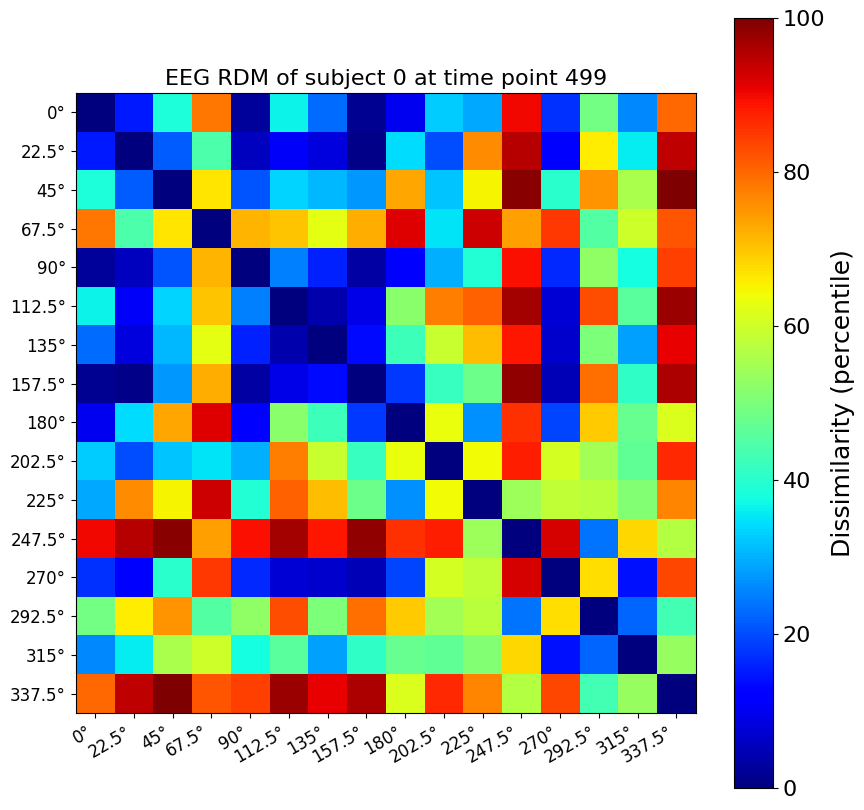

In [247]:
# A ready-made function: plot_rdm
subject_id = 0
time_point = 0
time_points = [0, 1, 498, 499]
for i, time_point in enumerate(time_points):
    fig = plt.figure(figsize=(10, 10))         # Resize the figure to make it easier to see
    visualise_EEG_RDM(subject_id, time_point)
    fig.savefig(f'images/ppt/eeg-rdm-subject-{subject_id}-timepoint-{time_point}.png')

#### Compare between Orientation RDM and EEG RDMs

**Goal:**
* Inputs: orientation RDM 16 * 16 and EEG RDMs 5 * 100 * 16 * 16
* Output of RSA results (representational similarities for each subject and each timepoint): 5 * 100

In [248]:
# This is the easiest way to calculate the similarity
# A ready-made function: rdms_corr()
help(rdms_corr)

Help on function rdms_corr in module neurora.corr_cal_by_rdm:

rdms_corr(demo_rdm, eeg_rdms, method='spearman', rescale=False, permutation=False, iter=1000)
    Calculate the similarity between RDMs based on RDMs of EEG-like data and a demo RDM
    
    Parameters
    ----------
    demo_rdm : array [n_cons, n_cons]
        A demo RDM.
    eeg_rdms : array
        The EEG/MEG/fNIRS/ECoG/sEEG/electrophysiological RDM(s).
        The shape can be [n_cons, n_cons] or [n1, n_cons, n_cons] or [n1, n2, n_cons, n_cons] or
        [n1, n2, n3, n_cons, n_cons]. ni(i=1, 2, 3) can be int(n_ts/timw_win), n_chls, n_subs.
    method : string 'spearman' or 'pearson' or 'kendall' or 'similarity' or 'distance'. Default is 'spearman'.
        The method to calculate the similarities.
        If method='spearman', calculate the Spearman Correlations. If method='pearson', calculate the Pearson
        Correlations. If methd='kendall', calculate the Kendall tau Correlations. If method='similarity', calcula

In [249]:
similarities = rdms_corr(oriRDM, eegRDMs)


Computing similarities

Computing finished!


In [250]:
print(similarities.shape)

(5, 500, 2)


#### Plot RSA-based decoding results

In [251]:
# This is the easiest way to plot RSA results
# A ready-made function: plot_tbytsim_withstats()
help(plot_tbytsim_withstats)

Help on function plot_tbytsim_withstats in module neurora.rsa_plot:

plot_tbytsim_withstats(similarities, start_time=0, end_time=1, time_interval=0.01, smooth=True, p=0.05, cbpt=True, clusterp=0.05, stats_time=[0, 1], color='r', xlim=[0, 1], ylim=[-0.1, 0.8], xlabel='Time (s)', ylabel='Representational Similarity', figsize=[6.4, 3.6], x0=0, ticksize=12, fontsize=16, markersize=2, title=None, title_fontsize=16, avgshow=False)
    Plot the time-by-time Similarities with statistical results
    
    Parameters
    ----------
    similarities : array
        The Similarities.
        The size of similarities should be [n_subs, n_ts] or [n_subs, n_ts, 2]. n_subs, n_ts represent the number of
        subjects and number of time-points. 2 represents the similarity and a p-value.
    start_time : int or float. Default is 0.
        The start time.
    end_time : int or float. Default is 1.
        The end time.
    time_interval : float. Default is 0.01.
        The time interval between two t


Significant time-windows:
-428ms to -416ms
244ms to 360ms
424ms to 616ms
671ms to 880ms


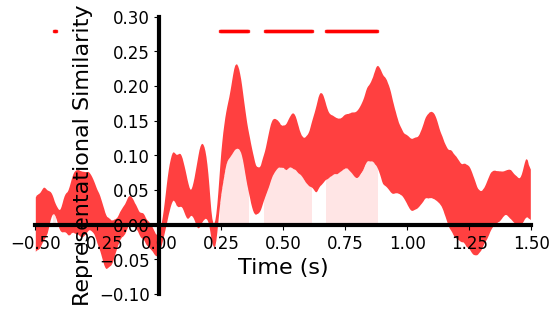

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [253]:
plot_tbytsim_withstats(similarities, start_time=-0.5, end_time=1.5, time_interval=0.004, p=0.05,
                       cbpt=False, stats_time=[0, 1.5], xlim=[-0.5, 1.5], ylim=[-0.1, 0.3])


Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!


Significant time-windows:
244ms to 360ms
424ms to 616ms
671ms to 880ms


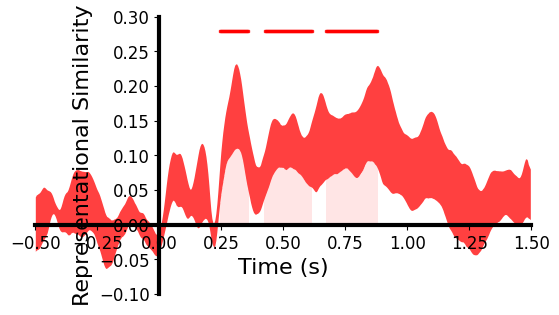

In [257]:
fig = plt.figure(figsize=(15, 5))         # Resize the figure to make it easier to see
plot_tbytsim_withstats(similarities, start_time=-0.5, end_time=1.5, time_interval=0.004, p=0.05,
                       cbpt=True, stats_time=[0, 1.5], xlim=[-0.5, 1.5], ylim=[-0.1, 0.3])
fig.savefig('images/ppt/rsa-based-decoding-result.png')